# 使用了lstm网络进行预测
# 数据集 为raw_data 其中数据为
# power, temperature, humidity, speed
# 电量，温度，湿度，风速
# 利用上一时刻的这些数据来进行预测此时的数据
# 标准为RSME，MAPE 

In [2]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np

In [3]:
# calculate MAPE
def mean_absolute_percentage_error(real, predict):
    res = 0
    count = 0
    for i in range(len(real)):
        if real[i] != 0:
            res += abs((predict[i]-real[i])/real[i])
            count += 1
    return res/count

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]

    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg



In [4]:
from pandas import read_csv
from datetime import datetime
# load data
dataset = read_csv('raw_data.csv',  index_col=0)
#print(dataset.values)
# manually specify column names
dataset.columns = ['power', 'temperature', 'humidity', 'speed']
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
#print(dataset.head(5))
# save to file
dataset.to_csv('power.csv')

In [1]:
# load dataset
'''
header = 0: 排除第一行数据； header = -1: 包含第一行数据；
index_col=0：排除第一列数据；index_col=-1：包含第一列数据；
'''
dataset = read_csv('power.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:, 4] = encoder.fit_transform(values[:, 4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1)).fit(values)
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_X.shape[1],train_X.shape[2])
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

with open("./ele_ac.txt",'w')as f:
    for i in range(240):
        f.write(str(yhat[i])+'\n')
        
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# calculate MAPE
mape = mean_absolute_percentage_error(inv_y, inv_yhat)
print('Test mape: %.3f' % mape)


NameError: name 'read_csv' is not defined

[401.33 343.43 353.82 385.36 708.82]
[439.09195 421.19293 369.3789  378.68155 406.97418]
8735


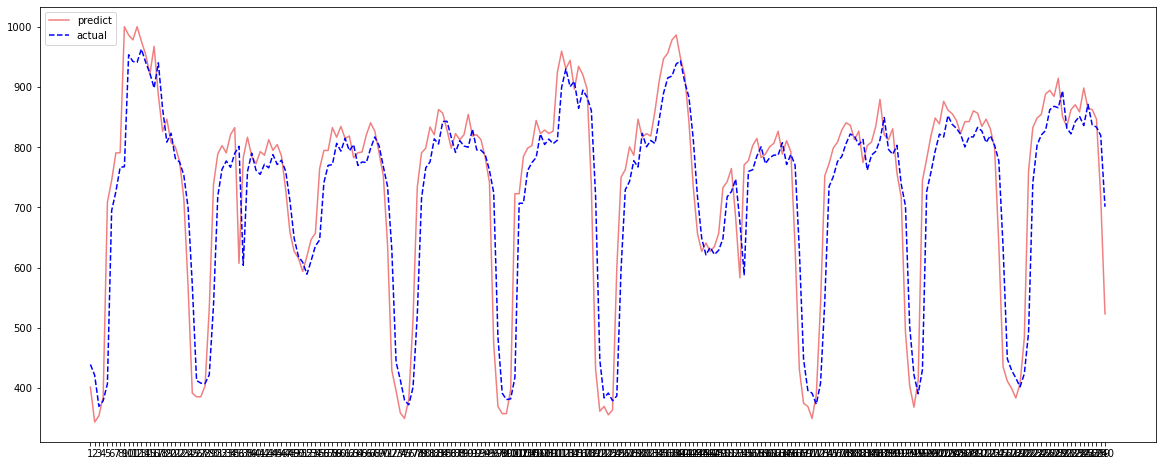

In [6]:
print(inv_y[:5])
print(inv_yhat[:5])
print(len(inv_y))
x = range(1,241)
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.plot(x,inv_y[:240],label='predict',color='#F08080')
plt.plot(x,inv_yhat[:240],label='actual',color='blue',linestyle='--')

_xtick_labels = ["{}".format(i) for i in x]

plt.xticks(x,_xtick_labels)

plt.legend(loc='upper left')
plt.savefig('lstm_pre.png')
plt.show()

#pyplot.plot()

In [14]:
with open("./ele_ac.txt",'w')as f:
    for i in range(240):
        f.write(str(inv_yhat[i])+'\n')